In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
df = pd.read_csv("all_ai_tool_raw.csv")

In [3]:
df.head()

,AI Tool Name,Description,Free/Paid/Other,Useable For,Charges,Review,Tool Link,Major Category
0,Farm3D,Learning Articulated 3D Animals by Distilling ...,Free,/ experiments / 3D,NaN,NaN,https://farm3d.github.io/?utm_source=futureped...,other
1,Mailbutler Ai,"AI-powered Smart Assistant for Outlook, Gmail ...",Freemium,/ email assistant,$ 4.95/mo,1,https://www.mailbutler.io/smart-assistant/?utm...,text
2,Maverick,Send customers personalized videos at scale.,Paid,/ e-commerce / audio editing,$ 100/mo,NaN,https://www.trymaverick.com/?utm_source=future...,audio
3,0Xai,Stable Diffusion Prompt And Images Generator,Free,/ image generator / prompts,NaN,NaN,https://0xai.quest?utm_source=futurepedia&utm_...,image
4,10Web,AI-powered WordPress platform for automated we...,Freemium,/ low-code/no-code,NaN,NaN,https://10web.io/?utm_source=futurepedia&utm_m...,code


In [4]:
X = df.loc[:, 'Description'] + df.loc[:, 'Useable For']
y = df.loc[:, 'Major Category']

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_vectorized = tfidf_vectorizer.fit_transform(X).todense().A

In [5]:
pca = PCA(n_components=2)

X_r = pca.fit(X_vectorized).transform(X_vectorized)

In [6]:
out = pd.DataFrame({
    "PCA1": X_r[:, 0],
    "PCA2": X_r[:, 1],
    "Major Category": df['Major Category']
}).to_csv("pca_ai_tool.csv",index_label="tool_id",decimal=",")

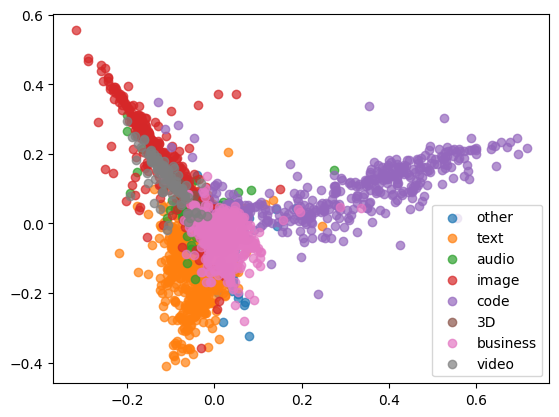

In [7]:
categories = df['Major Category'].unique()
for i, cat in enumerate(categories):
    ind = df.index[df['Major Category'] == cat]
    plt.scatter(X_r[ind, 0], X_r[ind, 1], label=cat, alpha=0.7)
plt.legend()
plt.show()

In [8]:
# Thanks to 'lightbeam' on Kaggle for this regex cleaning
# See https://www.kaggle.com/code/lightbeam/eda-in-python/notebook

charge_type_pattern = re.compile('(contact\s+for\s+pricing|free[\-\s]trial|deals)', re.IGNORECASE)

def simplify_pricing(charge_types):
    charge_types = charge_type_pattern.sub('Paid', charge_types)
    charge_types = charge_types.capitalize()
    for search, replacement in (('|', ' '),
                                ('Paidfree-trial', 'Paid'),
                                ('Freepaid', 'Free Paid'),
                                ('Freedeals', 'Free Paid'),
                                ('Freefreemium', 'Free Freemium')):
        charge_types = charge_types.replace(search, replacement)
    formatted_charge_types = []
    for charge_type in charge_types.split():
        formatted_charge_type = charge_type.strip()
        if formatted_charge_type not in ['', '/']:
            formatted_charge_types.append(formatted_charge_type.capitalize())
    return list(set(formatted_charge_types))[0]

df['Price category'] = df['Free/Paid/Other'].map(simplify_pricing)

In [9]:
def split_charges(df: pd.DataFrame) -> pd.DataFrame:
    for i, row in df.iterrows():
        charge = row['Charges']
        df.loc[i, 'Price USD'] =  ''
        df.loc[i, 'Unit'] = ''
        if pd.isna(charge):
            continue
        charge = charge.lower().replace("one-time", "").replace("free", "")
        split_string = [c for c in ("/", "per") if c in charge]
        if len(split_string) > 0:
            df.loc[i, 'Price USD'], *unit = charge.split(split_string[0])
            df.loc[i, 'Unit'] = "/".join(unit)
        else:
            df.loc[i, 'Price USD'] = charge
        df.loc[i, 'Price USD'] = df.loc[i, 'Price USD'].replace("$", "").strip()
    return df


In [10]:
df = split_charges(df)
# General data cleaning
df['Price USD'] = (df['Price USD']
                   .replace(r'c$', '', regex=True)
                   .replace(r'\d,\d*', '', regex=True)
                   .replace('', np.nan).astype(float)
                   )
df['Unit'] = (df['Unit']
              .apply(str.strip)
              .replace(np.nan, '')
              .replace("mo.", "mo")
              .replace("mo", "month")
              .replace("wk", "week")
              .replace("hr", "hour")
              .replace("min", "minute")
              .replace("yr", "year")
              .replace("", np.nan)
              )

In [11]:
df.loc[:, ~df.columns.isin(['Free/Paid/Other', 'Charges'])].to_csv("all_ai_tool.csv", index=False, decimal=',')